In [ ]:
# default_exp polynomials

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

# polynomials

> Polynomials approxmiations and SEAL polynomials evaluations

In [ ]:
# export
import tenseal.sealapi as seal
import numpy as np
from numpy.polynomial import Polynomial
from numpy.polynomial.chebyshev import Chebyshev

import matplotlib.pyplot as plt
import torch

from typing import List, Union

## Polynomials

In [ ]:
# export
def chebyshev_approximation(f, dilatation_factor=50, polynomial_degree=25, bound=1, convertToTensor=True):
    if convertToTensor:
        f_a = lambda x: f(torch.tensor(x*dilatation_factor))
    else:
        f_a = lambda x: f(x*dilatation_factor)
        
    domain = [-bound,bound]

    p = Chebyshev.interpolate(f_a,deg=polynomial_degree,domain=domain)
    return p, f_a

def polynomial_approximation_coefficients(f, dilatation_factor=50, polynomial_degree=25, 
                                          bound=1, convertToTensor=True):
    p,_ = chebyshev_approximation(f, dilatation_factor, polynomial_degree, bound, convertToTensor)
    
    return Polynomial.cast(p).coef

def plot_graph_function_approximation(f, dilatation_factor=50, polynomial_degree=25, bound=1, convertToTensor=True):
    
    p, f_a = chebyshev_approximation(f, dilatation_factor, polynomial_degree, bound, convertToTensor)
    
    domain = [-bound,bound]
    x = np.linspace(*domain,100)
    y = f_a(x)
    pred = p(x)

    fig, ax = plt.subplots()

    # plot the function
    ax.plot(x,y, 'g', label="Sigmoid")
    ax.plot(x,pred,"b-", label=f"Polynomial approximation")
    ax.legend()

    # show the plot
    fig.suptitle(f"Tchebytchev polynomials with expansion a={dilatation_factor} and degree n={polynomial_degree}")
    fig.show()
    
    return fig,ax

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd434491910>)

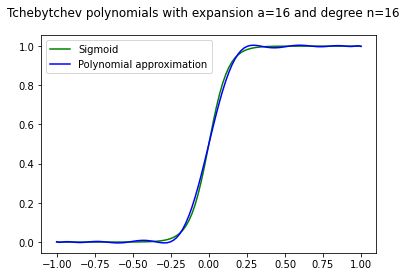

In [ ]:
dilatation_factor = 16
degree = 16

p,_ = chebyshev_approximation(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)
coeffs = polynomial_approximation_coefficients(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)
plot_graph_function_approximation(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)

## Homorphic evaluation of polynomials

In [ ]:
# export
def coeffs_to_plaintext(coeffs: List[float], encoder: seal.CKKSEncoder, scale: float) -> List[seal.Plaintext]:
    """Computes the plaintext encodings of coefficients"""
    plain_coeffs = []

    for coef in coeffs:
        plain_coeff = seal.Plaintext()
        encoder.encode(coef, scale, plain_coeff)
        plain_coeffs.append(plain_coeff)
        
    return plain_coeffs

def compute_all_powers(ctx : seal.Ciphertext, degree: int, evaluator: seal.Evaluator, 
                       relin_keys: seal.RelinKeys, verbose=False) -> List[seal.Ciphertext]:
    """Computes all powers of a given ciphertext"""
    powers = [None] * (degree+1)
    levels = np.zeros(degree+1)

    powers[1] = ctx
    levels[0] = levels[1] = 0
    
    
    for i in range(2,degree+1):
            
        minlevel = i
        cand = -1
        
        for j in range(1, i // 2 +1):
            k = i - j
            newlevel = max(levels[k],levels[j]) + 1
            if newlevel < minlevel:
                cand = j
                minlevel = newlevel
                
        if verbose:
            print(f"i = {i}, i-cand = {i-cand}")
            print(f"level for cand : {levels[cand]}, level for {i-cand} : {levels[i-cand]}")
            print(f"minlevel = {minlevel}")
            print(f"cand = {cand}")
        
        levels[i] = minlevel
        
        temp = seal.Ciphertext()
        
        power_cand = powers[cand]
        evaluator.mod_switch_to(power_cand, powers[i-cand].parms_id(),temp)
        evaluator.multiply(temp, powers[i-cand], temp)
        evaluator.relinearize_inplace(temp, relin_keys)
        evaluator.rescale_to_next_inplace(temp)
        
        powers[i] = temp
        
    return powers

In [ ]:
import builtins
from cryptotree.seal_helper import print_ctx, print_ptx, create_seal_globals, append_globals_to_builtins
import tenseal.sealapi as seal

poly_modulus_degree = 8192
moduli = [40,30,30,40]
PRECISION_BITS = 30

create_seal_globals(globals(), poly_modulus_degree, moduli, PRECISION_BITS)
append_globals_to_builtins(globals(), builtins)

ptx = seal.Plaintext()
encoder.encode(2, scale, ptx)

print("Initial vector input : ") 
print_ptx(ptx)

ctx = seal.Ciphertext()
encryptor.encrypt(ptx, ctx)

degree = 2
powers = compute_all_powers(ctx, degree, evaluator, relin_keys)

print("Powers computed : ")
print_ctx(powers[1])
print_ctx(powers[2])

Initial vector input : 

    [ 2.0000000, 2.0000000, 2.0000000, ..., 2.0000000, 2.0000000, 2.0000000 ]

Powers computed : 

    [ 2.0000001, 2.0000009, 2.0000001, ..., 1.9999987, 1.9999991, 1.9999984 ]


    [ 3.9999991, 4.0000031, 3.9999984, ..., 3.9999971, 3.9999974, 3.9999914 ]



In [ ]:
# export
from typing import List, Union

def multiply_and_add_coeffs(powers: List[seal.Ciphertext], plain_coeffs: List[seal.Plaintext],
                            coeffs: List[float],
                            evaluator: seal.Evaluator,
                            scale: float,
                            tol=1e-6) -> Union[seal.Ciphertext]:
    assert len(powers) == len(plain_coeffs), f"Mismatch between length between powers {len(powers)} and coeffs {len(coeffs)}"
    
    """Multiplies the coefficients with the corresponding powers andd adds everything.
    
    If the polynomial is non-constant, returns the ciphertext of the polynomial evaluation.
    Else if the polynomials is constant, the plaintext of the constant term is returned.
    """
    output = seal.Ciphertext()
    a0 = plain_coeffs[0]
    a0_added = False
    
    temp = seal.Ciphertext()
    
    for i in range(1, len(plain_coeffs)):
        # We first check if the coefficient is not too small otherwise we skip it
        coef = coeffs[i]
        if np.abs(coef) < tol:
            continue
            
        plain_coeff = plain_coeffs[i]
        power = powers[i]
        
        evaluator.mod_switch_to_inplace(plain_coeff, power.parms_id())
        
        evaluator.multiply_plain(power, plain_coeff, temp)
        evaluator.rescale_to_next_inplace(temp)
        
        if not a0_added:
            evaluator.mod_switch_to_inplace(a0, temp.parms_id())
            
            temp.scale = scale
            evaluator.add_plain(temp, a0, output)
            a0_added = True
        else:
            evaluator.mod_switch_to_inplace(output, temp.parms_id())
            # We rescale both to the same scale
            output.scale = scale
            temp.scale = scale
            evaluator.add_inplace(output, temp)
    if a0_added:
        return output
    else:
        return a0

In [ ]:
# export
def polyeval_tree(ctx : seal.Ciphertext, coeffs: List[float], 
                  evaluator: seal.Evaluator, encoder : seal.Encryptor,
                  relin_keys: seal.RelinKeys,
                  scale: float):
    
    degree = len(coeffs) - 1
    plain_coeffs = coeffs_to_plaintext(coeffs, encoder, scale)
    powers = compute_all_powers(ctx, degree, evaluator, relin_keys)
    output = multiply_and_add_coeffs(powers, plain_coeffs, coeffs, evaluator, scale)
    
    return output

In [ ]:
coeffs = [1,0,1]

ptx = seal.Plaintext()
encoder.encode(2, scale, ptx)

print("Initial vector input : ") 
print_ptx(ptx)

ctx = seal.Ciphertext()
encryptor.encrypt(ptx, ctx)

output = polyeval_tree(ctx, coeffs, evaluator, encoder, relin_keys, scale)

print("Polynomial considered : X^2 + 1")
print(f"Associated coeffs : {coeffs}")
print("Output of polynomials : ")
print_ctx(output)

Initial vector input : 

    [ 2.0000000, 2.0000000, 2.0000000, ..., 2.0000000, 2.0000000, 2.0000000 ]

Polynomial considered : X^2 + 1
Associated coeffs : [1, 0, 1]
Output of polynomials : 

    [ 5.0005520, 5.0005480, 5.0005467, ..., 5.0005472, 5.0005464, 5.0005410 ]



In [ ]:
# export
from fastcore.test import test_close

def eval_polynomial(x: float, coeffs):
    output = 0.
    for power,coeff in enumerate(coeffs):
        output += coeff * (x ** power)
    return output

def test_polynomial(x: float, coeffs, evaluator, encoder, encryptor, decryptor, relin_keys, scale, eps=1e-2):
    """Tests if the output of the polynomial, defined by the coeffs, is the same
    between the homomorphic evaluation and the regular one"""
    
    ptx = seal.Plaintext()
    encoder.encode(x, scale, ptx)
    
    ctx = seal.Ciphertext()
    encryptor.encrypt(ptx, ctx)
    
    output = polyeval_tree(ctx, coeffs, evaluator, encoder, relin_keys, scale)
    decryptor.decrypt(output, ptx)
    
    values = encoder.decode_double(ptx)
    
    homomorphic_output = values[0]
    expected_output = eval_polynomial(x, coeffs)
    
    test_close(homomorphic_output, expected_output, eps)

In [ ]:
test_polynomial(2, [1,0,1], evaluator, encoder, encryptor, decryptor, relin_keys, scale)
test_polynomial(1, [1,1], evaluator, encoder, encryptor, decryptor, relin_keys, scale)
test_polynomial(3, [0,0,1], evaluator, encoder, encryptor, decryptor, relin_keys, scale)